<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('excel_vcb.csv')
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

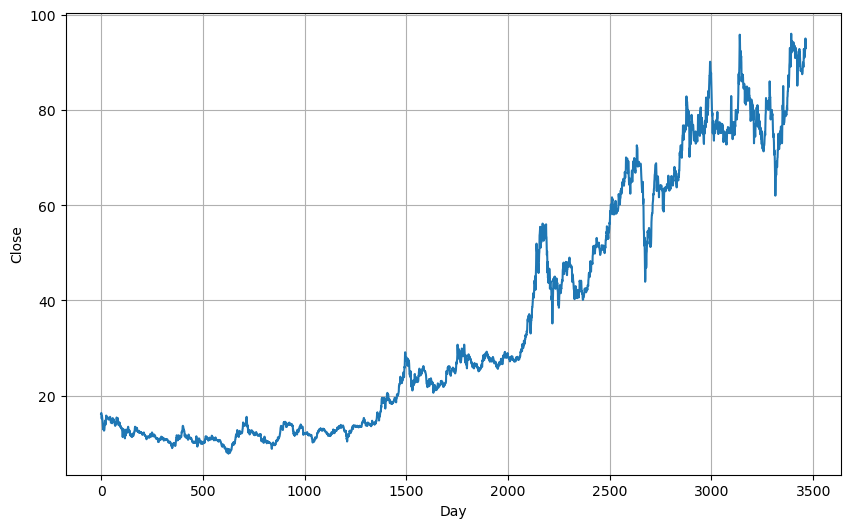

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
93/93 [==============================] - 9s 52ms/step - loss: 47.1992 - mae: 47.6911
Epoch 2/100
93/93 [==============================] - 3s 29ms/step - loss: 3.1806 - mae: 3.6491
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 1.5797 - mae: 2.0104
Epoch 4/100
93/93 [==============================] - 2s 22ms/step - loss: 0.5843 - mae: 0.9378
Epoch 5/100
93/93 [==============================] - 2s 24ms/step - loss: 0.5395 - mae: 0.9026
Epoch 6/100
93/93 [==============================] - 3s 25ms/step - loss: 0.4322 - mae: 0.7588
Epoch 7/100
93/93 [==============================] - 3s 25ms/step - loss: 0.3878 - mae: 0.7170
Epoch 8/100
93/93 [==============================] - 2s 25ms/step - loss: 0.4353 - mae: 0.7501
Epoch 9/100
93/93 [==============================] - 2s 23ms/step - loss: 0.3657 - mae: 0.6885
Epoch 10/100
93/93 [==============================] - 2s 22ms/step - loss: 0.4061 - mae: 0.7246
Epoch 11/100
93/93 [===========================

In [7]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 1s 18ms/step
Thời gian dự đoán mô hình DNN: 1.0973 giây


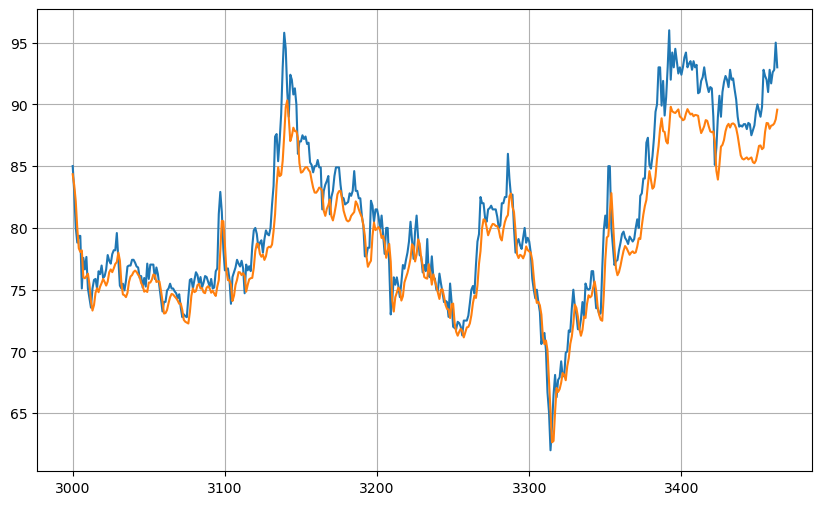

[84.34815  83.454315 82.17258  79.98726  78.35204  78.05808  78.18057
 75.994965 75.927025 76.08881  76.29363  75.44832  74.07492  73.31021
 73.75745  74.74542  75.11257  74.79762  75.23927  75.53358  75.86966
 75.6253   75.33223  75.656876 76.41508  76.63917  76.419655 76.729515
 77.08793  77.23949  78.001945 77.36023  75.53606  74.61314  74.549446
 74.40008  74.74309  75.63514  76.06944  76.18148  76.434235 76.54412
 76.43532  76.20781  76.03448  75.52563  75.3169   74.83921  74.92707
 74.81471  75.57351  75.57734  75.80344  76.23012  76.17371  75.622055
 75.682106 75.65997  74.937454 74.07797  73.07126  73.103424 73.35838
 73.921875 74.394615 74.657326 74.60601  74.45188  74.312416 74.12129
 73.857895 73.88623  73.37177  72.56147  72.405464 72.32926  72.26277
 73.18743  74.5113   75.10296  74.80156  74.885216 75.373726 75.47017
 75.09379  75.12751  74.78327  74.71653  75.161354 75.28029  75.10491
 74.75544  74.917885 74.684326 74.49206  75.237564 75.77409  78.16644
 80.57569  80.538

In [8]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast
import time
# Bắt đầu tính thời gian dự đoán
start_time = time.time()
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
# Kết thúc tính thời gian huấn luyện
train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình DNN: {train_time_cls:.4f} giây')
# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
import time
# Bắt đầu tính thời gian dự đoán
start_time = time.time()
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
# Kết thúc tính thời gian huấn luyện
train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình DNN: {train_time_cls:.4f} giây')
# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

In [10]:
import time
# Bắt đầu tính thời gian dự đoán
start_time = time.time()
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
# Kết thúc tính thời gian huấn luyện
train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình DNN: {train_time_cls:.4f} giây')
# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

MSE: 24.401583
Mean Error Percent: 0.05503933390150497
Accuracy: 0.944960666098495


In [ ]:
import pandas as pd

data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\ACB.csv')
data.head


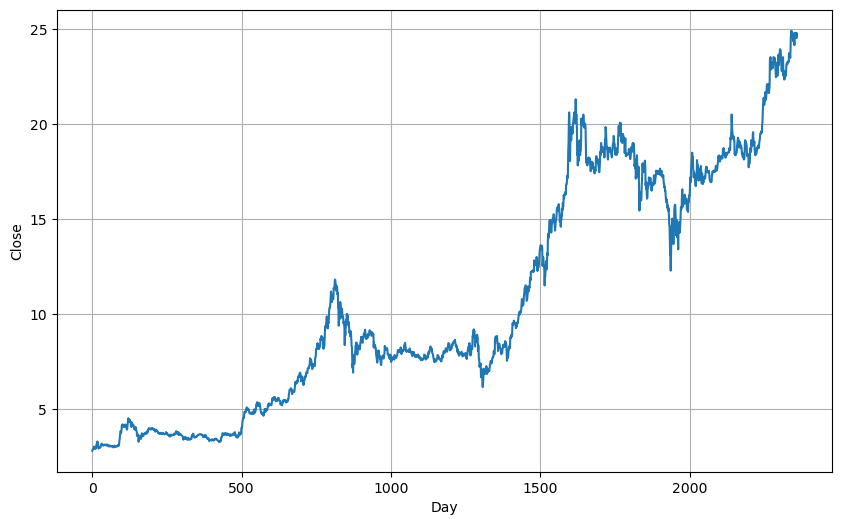

In [7]:

# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\ACB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

## Split the Dataset

In [8]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [22]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [24]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [25]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 30)
shape of label: (32,)


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`. 

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [26]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 30, 1)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 30, 40)            1680      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [15]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 5s 20ms/step - loss: 138.2984 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 18ms/step - loss: 134.7177 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 19ms/step - loss: 130.5961 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 19ms/step - loss: 125.9351 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 19ms/step - loss: 120.6587 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 18ms/step - loss: 114.6727 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 19ms/step - loss: 107.8669 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 18ms/step - loss: 100.1091 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 19ms/step - loss: 91.2506 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 19ms/step - loss: 81.1297 - lr: 2.8184e-08
E

You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

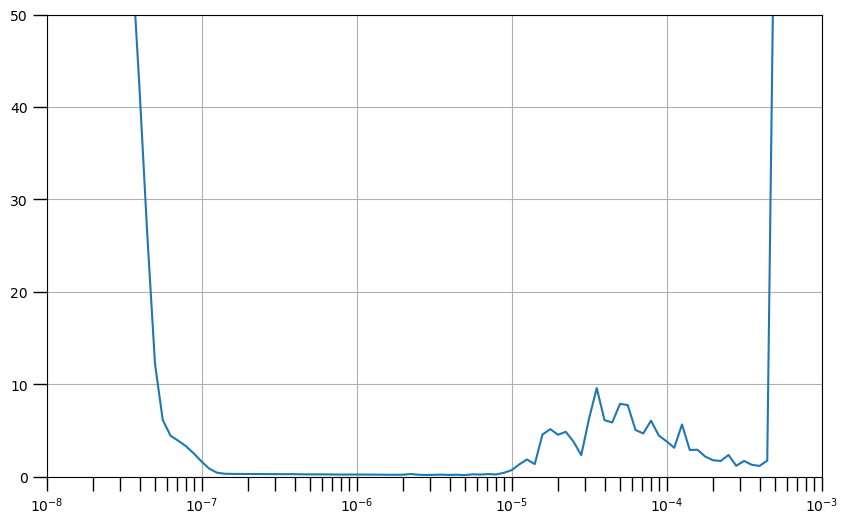

In [16]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

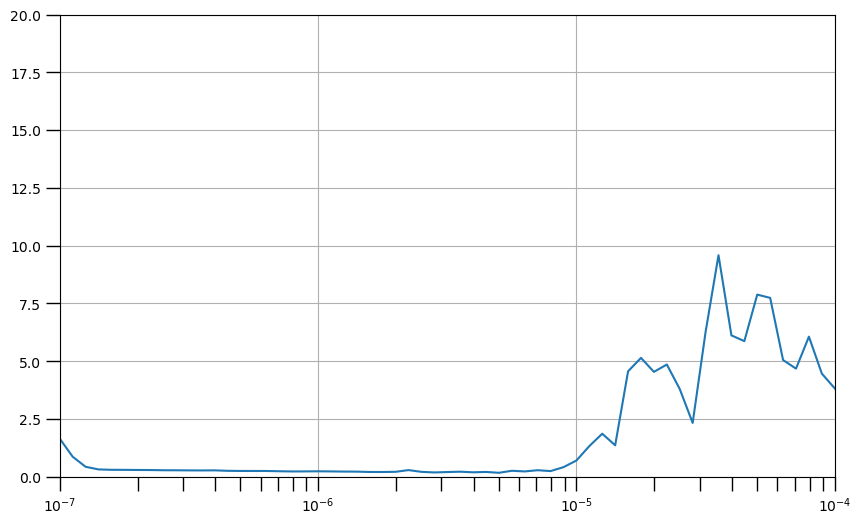

In [17]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [27]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
62/62 [==============================] - 6s 26ms/step - loss: 19.1553 - mae: 19.6350
Epoch 2/100
62/62 [==============================] - 2s 26ms/step - loss: 1.5252 - mae: 1.9441
Epoch 3/100
62/62 [==============================] - 2s 31ms/step - loss: 0.7966 - mae: 1.2005
Epoch 4/100
62/62 [==============================] - 2s 27ms/step - loss: 0.5801 - mae: 0.9652
Epoch 5/100
62/62 [==============================] - 2s 29ms/step - loss: 0.4705 - mae: 0.8476
Epoch 6/100
62/62 [==============================] - 2s 24ms/step - loss: 0.3803 - mae: 0.7397
Epoch 7/100
62/62 [==============================] - 2s 24ms/step - loss: 0.2970 - mae: 0.6349
Epoch 8/100
62/62 [==============================] - 2s 28ms/step - loss: 0.2732 - mae: 0.6038
Epoch 9/100
62/62 [==============================] - 2s 27ms/step - loss: 0.2492 - mae: 0.5645
Epoch 10/100
62/62 [==============================] - 2s 26ms/step - loss: 0.2355 - mae: 0.5549
Epoch 11/100
62/62 [===========================

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

1/1 [==============================] - 0s 415ms/step


1/1 [==============================] - 0s 242ms/step


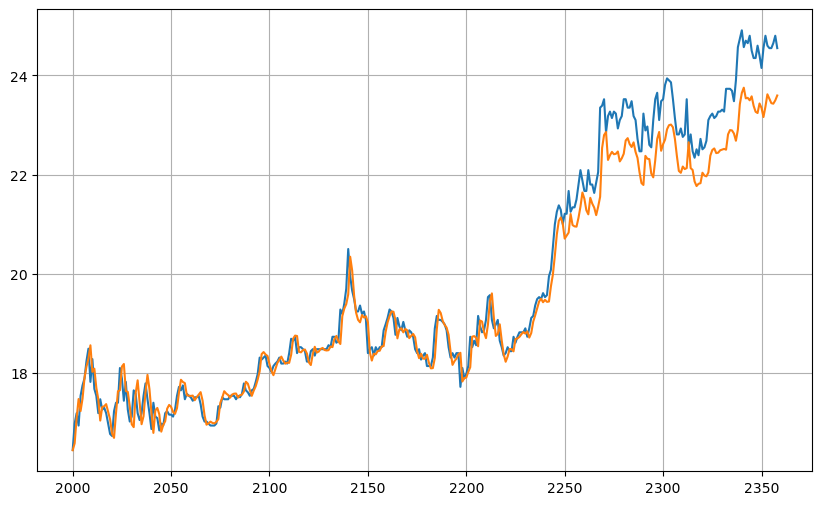

In [28]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [19]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

12/12 [==============================] - 4s 25ms/step


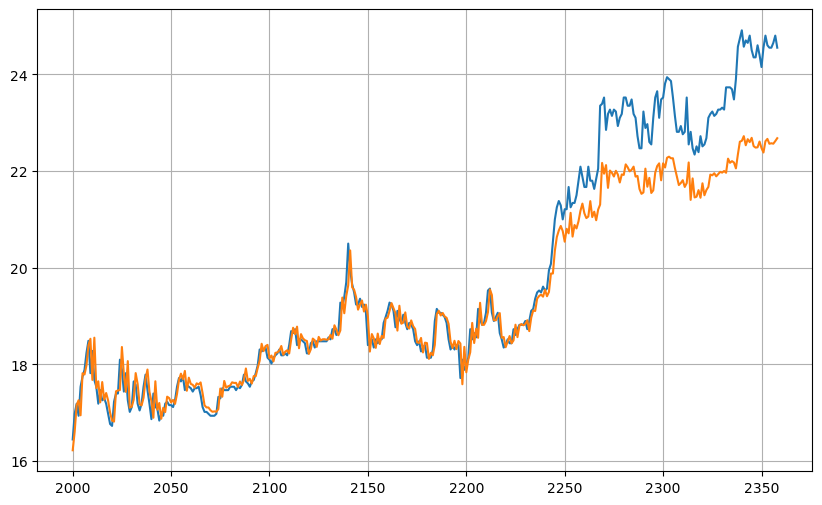

In [20]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [21]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.63880235
0.5267523


In [15]:
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
mean_error_percent = np.mean(np.abs((x_valid- results) / x_valid))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [464] vs. [0] [Op:SquaredDifference]

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv

# Hàm vẽ dữ liệu
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Định nghĩa tham số
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
split_time = 3000

# Hàm tạo cửa sổ dữ liệu
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Khởi tạo mô hình
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

# Tạo file kết quả
output_file = 'model_results.csv'
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Filename', 'MSE', 'Accuracy', 'mean_error_percent'])

# Dự báo cho từng tệp
folder_path = 'D:\DeTaiNam2024\SoLieuHong'  # Đường dẫn thư mục chứa các file CSV
output_results = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Đọc dữ liệu từ CSV
        data = pd.read_csv(file_path)
        time_step = data['time'].values  # Thay thế với tên cột thời gian
        close = data['close'].values  # Thay thế với tên cột giá đóng cửa
        
        time = np.array(time_step)
        series = np.array(close)
        
        # Phân chia tập huấn luyện và xác thực
        time_train = time[:split_time]
        x_train = series[:split_time]
        time_valid = time[split_time:]
        x_valid = series[split_time:]

        # Chuẩn bị dữ liệu cho mô hình
        dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
        
        # Xây dựng và huấn luyện mô hình
        model = create_model()
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
        
        
        model.fit(dataset, epochs=100)
       
       


              
        # Dự báo trên tập xác thực
        forecast_series = series[split_time - window_size:]
        forecast = []
        for t in range(len(forecast_series) - window_size):
            forecast.append(model.predict(forecast_series[t:t + window_size][np.newaxis]))
        results = np.array(forecast).squeeze()
         # Giả sử x_valid và results là các mảng dự đoán và giá trị thực
        x_valid = np.array(x_valid)
        results = np.array(results)

        # Tính Mean Squared Error
        mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()


        # Tính Mean Absolute Percentage Error (MAPE)
        non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
        mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
        accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE
        # Lưu kết quả vào file CSV
        with open(output_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([filename,  mse, accuracy, mean_error_percent])
        
        
        
print("Lưu kết quả vào file CSV thành công.")


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
73/73 [==============================] - 24s 326ms/step - loss: 451.8011 - mae: 12.2853
Epoch 2/100
73/73 [==============================] - 29s 390ms/step - loss: 3.2168 - mae: 1.3100
Epoch 3/100
73/73 [==============================] - 29s 388ms/step - loss: 0.8125 - mae: 0.6820
Epoch 4/100
73/73 [==============================] - 28s 387ms/step - loss: 0.3092 - mae: 0.4169
Epoch 5/100
73/73 [==============================] - 28s 375ms/step - loss: 0.2269 - mae: 0.3601
Epoch 6/100
73/73 [==============================] - 29s 392ms/step - loss: 0.1923 - mae: 0.3315
Epoch 7/100
73/73 [==============================] - 28s 377ms/step - loss: 0.1633 - mae: 0.3016
Epoch 8/100
73/73 [==============================] - 30s 409ms/step - loss: 0.1414 - mae: 0.2785
Epoch 9/100
73/73 [==============================] - 30s 405ms/step - loss: 0.1290 - mae: 0.2657
Epoch 10/100
73/73 [==============================] - 27s 365ms/step - loss: 0.1255 - mae: 0.2620
Epoch 11/100
73/73 [======

73/73 [==============================] - 27s 361ms/step - loss: 0.0743 - mae: 0.1944
Epoch 85/100
73/73 [==============================] - 25s 345ms/step - loss: 0.0827 - mae: 0.2067
Epoch 86/100
73/73 [==============================] - 26s 357ms/step - loss: 0.0729 - mae: 0.1886
Epoch 87/100
73/73 [==============================] - 26s 356ms/step - loss: 0.0742 - mae: 0.1925
Epoch 88/100
73/73 [==============================] - 27s 362ms/step - loss: 0.0709 - mae: 0.1884
Epoch 89/100
73/73 [==============================] - 24s 330ms/step - loss: 0.0719 - mae: 0.1912
Epoch 90/100
73/73 [==============================] - 25s 337ms/step - loss: 0.0718 - mae: 0.1874
Epoch 91/100
73/73 [==============================] - 25s 345ms/step - loss: 0.0735 - mae: 0.1937
Epoch 92/100
73/73 [==============================] - 25s 334ms/step - loss: 0.0861 - mae: 0.2121
Epoch 93/100
73/73 [==============================] - 25s 337ms/step - loss: 0.0795 - mae: 0.2031
Epoch 94/100
73/73 [=============

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 26s 339ms/step - loss: 788.0219 - mae: 20.1763
Epoch 2/100
75/75 [==============================] - 27s 354ms/step - loss: 484.1837 - mae: 16.7597
Epoch 3/100
75/75 [==============================] - 28s 376ms/step - loss: 539.1824 - mae: 17.2627
Epoch 4/100
75/75 [==============================] - 27s 354ms/step - loss: 456.2187 - mae: 16.2522
Epoch 5/100
75/75 [==============================] - 27s 352ms/step - loss: 468.8182 - mae: 16.2000
Epoch 6/100
75/75 [==============================] - 25s 337ms/step - loss: 440.9801 - mae: 15.7169
Epoch 7/100
75/75 [==============================] - 26s 339ms/step - loss: 478.0316 - mae: 16.5154
Epoch 8/100
75/75 [==============================] - 25s 333ms/step - loss: 500.9296 - mae: 17.0430
Epoch 9/100
75/75 [==============================] - 25s 335ms/step - loss: 445.9152 - mae: 15.7887
Epoch 10/100
75/75 [==============================] - 25s 332ms/step - loss: 378.6316 - mae: 14.7665

75/75 [==============================] - 24s 311ms/step - loss: 439.2567 - mae: 15.5893
Epoch 83/100
75/75 [==============================] - 23s 309ms/step - loss: 429.9845 - mae: 15.6821
Epoch 84/100
75/75 [==============================] - 23s 308ms/step - loss: 434.6826 - mae: 15.6078
Epoch 85/100
75/75 [==============================] - 22s 295ms/step - loss: 428.5667 - mae: 15.7289
Epoch 86/100
75/75 [==============================] - 22s 294ms/step - loss: 441.0601 - mae: 15.8420
Epoch 87/100
75/75 [==============================] - 22s 293ms/step - loss: 422.3753 - mae: 15.3080
Epoch 88/100
75/75 [==============================] - 22s 297ms/step - loss: 435.2382 - mae: 15.6338
Epoch 89/100
75/75 [==============================] - 23s 299ms/step - loss: 423.9563 - mae: 15.7264
Epoch 90/100
75/75 [==============================] - 22s 297ms/step - loss: 450.7308 - mae: 16.0711
Epoch 91/100
75/75 [==============================] - 22s 297ms/step - loss: 443.2393 - mae: 15.8158
Epo

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 23s 300ms/step - loss: 433.9706 - mae: 15.0939
Epoch 2/100
75/75 [==============================] - 22s 296ms/step - loss: 287.3824 - mae: 10.4893
Epoch 3/100
75/75 [==============================] - 23s 299ms/step - loss: 303.1614 - mae: 12.4231
Epoch 4/100
75/75 [==============================] - 23s 304ms/step - loss: 548.7942 - mae: 18.4327
Epoch 5/100
75/75 [==============================] - 22s 295ms/step - loss: 759.6011 - mae: 21.4132
Epoch 6/100
75/75 [==============================] - 22s 298ms/step - loss: 900.2045 - mae: 23.4814
Epoch 7/100
75/75 [==============================] - 23s 301ms/step - loss: 536.1469 - mae: 17.7339
Epoch 8/100
75/75 [==============================] - 25s 332ms/step - loss: 662.4472 - mae: 20.2671
Epoch 9/100
75/75 [==============================] - 27s 361ms/step - loss: 640.0177 - mae: 20.1584
Epoch 10/100
75/75 [==============================] - 28s 372ms/step - loss: 413.2322 - mae: 14.2865

75/75 [==============================] - 23s 299ms/step - loss: 473.8628 - mae: 15.7482
Epoch 83/100
75/75 [==============================] - 23s 300ms/step - loss: 523.3986 - mae: 17.8434
Epoch 84/100
75/75 [==============================] - 22s 293ms/step - loss: 573.4529 - mae: 18.5857
Epoch 85/100
75/75 [==============================] - 22s 297ms/step - loss: 557.9327 - mae: 18.6972
Epoch 86/100
75/75 [==============================] - 22s 293ms/step - loss: 437.7142 - mae: 16.4580
Epoch 87/100
75/75 [==============================] - 22s 295ms/step - loss: 421.0340 - mae: 15.2269
Epoch 88/100
75/75 [==============================] - 22s 293ms/step - loss: 464.4056 - mae: 16.1983
Epoch 89/100
75/75 [==============================] - 22s 294ms/step - loss: 637.5311 - mae: 19.7388
Epoch 90/100
75/75 [==============================] - 22s 296ms/step - loss: 509.2952 - mae: 16.1046
Epoch 91/100
75/75 [==============================] - 22s 295ms/step - loss: 668.8600 - mae: 19.8008
Epo

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 22s 292ms/step - loss: 402.2004 - mae: 11.3775
Epoch 2/100
75/75 [==============================] - 23s 301ms/step - loss: 0.4993 - mae: 0.5208
Epoch 3/100
75/75 [==============================] - 23s 301ms/step - loss: 0.1520 - mae: 0.2949
Epoch 4/100
75/75 [==============================] - 23s 303ms/step - loss: 0.1241 - mae: 0.2619
Epoch 5/100
75/75 [==============================] - 23s 299ms/step - loss: 0.1087 - mae: 0.2445
Epoch 6/100
75/75 [==============================] - 23s 300ms/step - loss: 0.1162 - mae: 0.2531
Epoch 7/100
75/75 [==============================] - 23s 306ms/step - loss: 0.1125 - mae: 0.2499
Epoch 8/100
75/75 [==============================] - 23s 298ms/step - loss: 0.1031 - mae: 0.2350
Epoch 9/100
75/75 [==============================] - 23s 299ms/step - loss: 0.1016 - mae: 0.2367
Epoch 10/100
75/75 [==============================] - 23s 301ms/step - loss: 0.0888 - mae: 0.2171
Epoch 11/100
75/75 [======

75/75 [==============================] - 22s 295ms/step - loss: 0.0488 - mae: 0.1501
Epoch 85/100
75/75 [==============================] - 23s 298ms/step - loss: 0.0536 - mae: 0.1620
Epoch 86/100
75/75 [==============================] - 25s 326ms/step - loss: 0.0508 - mae: 0.1584
Epoch 87/100
75/75 [==============================] - 22s 292ms/step - loss: 0.0500 - mae: 0.1555
Epoch 88/100
75/75 [==============================] - 23s 297ms/step - loss: 0.0469 - mae: 0.1459
Epoch 89/100
75/75 [==============================] - 23s 299ms/step - loss: 0.0507 - mae: 0.1584
Epoch 90/100
75/75 [==============================] - 23s 305ms/step - loss: 0.0489 - mae: 0.1533
Epoch 91/100
75/75 [==============================] - 22s 291ms/step - loss: 0.0464 - mae: 0.1466
Epoch 92/100
75/75 [==============================] - 25s 329ms/step - loss: 0.0526 - mae: 0.1598
Epoch 93/100
75/75 [==============================] - 25s 324ms/step - loss: 0.0578 - mae: 0.1714
Epoch 94/100
75/75 [=============

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
53/53 [==============================] - 16s 291ms/step - loss: nan - mae: nan
Epoch 2/100
53/53 [==============================] - 16s 300ms/step - loss: nan - mae: nan
Epoch 3/100
53/53 [==============================] - 16s 300ms/step - loss: nan - mae: nan
Epoch 4/100
53/53 [==============================] - 16s 307ms/step - loss: nan - mae: nan
Epoch 5/100
53/53 [==============================] - 14s 268ms/step - loss: nan - mae: nan
Epoch 6/100
53/53 [==============================] - 16s 295ms/step - loss: nan - mae: nan
Epoch 7/100
53/53 [==============================] - 14s 265ms/step - loss: nan - mae: nan
Epoch 8/100
53/53 [==============================] - 16s 295ms/step - loss: nan - mae: nan
Epoch 9/100
53/53 [==============================] - 15s 271ms/step - loss: nan - mae: nan
Epoch 10/100
53/53 [==============================] - 15s 275ms/step - loss: nan - mae: nan
Epoch 11/100
53/53 [==============================] - 14s 269ms/step - loss: nan - mae: n

53/53 [==============================] - 15s 280ms/step - loss: nan - mae: nan
Epoch 91/100
53/53 [==============================] - 15s 285ms/step - loss: nan - mae: nan
Epoch 92/100
53/53 [==============================] - 14s 270ms/step - loss: nan - mae: nan
Epoch 93/100
53/53 [==============================] - 15s 284ms/step - loss: nan - mae: nan
Epoch 94/100
53/53 [==============================] - 15s 283ms/step - loss: nan - mae: nan
Epoch 95/100
53/53 [==============================] - 15s 284ms/step - loss: nan - mae: nan
Epoch 96/100
53/53 [==============================] - 15s 278ms/step - loss: nan - mae: nan
Epoch 97/100
53/53 [==============================] - 16s 289ms/step - loss: nan - mae: nan
Epoch 98/100
53/53 [==============================] - 16s 307ms/step - loss: nan - mae: nan
Epoch 99/100
53/53 [==============================] - 72s 1s/step - loss: nan - mae: nan
Epoch 100/100
53/53 [==============================] - 87s 2s/step - loss: nan - mae: nan


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
55/55 [==============================] - 32s 563ms/step - loss: 30411.2012 - mae: 136.0116
Epoch 2/100
55/55 [==============================] - 17s 305ms/step - loss: 30428.6699 - mae: 141.1025
Epoch 3/100
55/55 [==============================] - 16s 286ms/step - loss: 35922.0469 - mae: 153.4998
Epoch 4/100
55/55 [==============================] - 17s 301ms/step - loss: 37910.2539 - mae: 159.8040
Epoch 5/100
55/55 [==============================] - 17s 305ms/step - loss: 25540.3613 - mae: 127.1776
Epoch 6/100
55/55 [==============================] - 18s 322ms/step - loss: 30526.7051 - mae: 140.2578
Epoch 7/100
55/55 [==============================] - 18s 319ms/step - loss: 31781.6758 - mae: 139.6779
Epoch 8/100
55/55 [==============================] - 18s 329ms/step - loss: 33874.1367 - mae: 150.8375
Epoch 9/100
55/55 [==============================] - 17s 306ms/step - loss: 33572.0430 - mae: 150.1095
Epoch 10/100
55/55 [==============================] - 17s 299ms/step - lo

55/55 [==============================] - 14s 258ms/step - loss: 25050.5332 - mae: 124.2205
Epoch 81/100
55/55 [==============================] - 14s 259ms/step - loss: 32548.3867 - mae: 145.4512
Epoch 82/100
55/55 [==============================] - 14s 258ms/step - loss: 30075.5840 - mae: 139.2524
Epoch 83/100
55/55 [==============================] - 14s 259ms/step - loss: 32450.1719 - mae: 147.4634
Epoch 84/100
55/55 [==============================] - 14s 258ms/step - loss: 36020.7930 - mae: 153.0738
Epoch 85/100
55/55 [==============================] - 14s 260ms/step - loss: 32993.3242 - mae: 146.6849
Epoch 86/100
55/55 [==============================] - 14s 259ms/step - loss: 31131.9629 - mae: 142.5981
Epoch 87/100
55/55 [==============================] - 14s 258ms/step - loss: 28941.6992 - mae: 139.2902
Epoch 88/100
55/55 [==============================] - 14s 258ms/step - loss: 30599.5527 - mae: 141.8094
Epoch 89/100
55/55 [==============================] - 14s 258ms/step - loss: 

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 20s 264ms/step - loss: 138.3459 - mae: 7.1361
Epoch 2/100
75/75 [==============================] - 20s 264ms/step - loss: 2.5513 - mae: 1.0938
Epoch 3/100
75/75 [==============================] - 20s 261ms/step - loss: 0.3198 - mae: 0.4120
Epoch 4/100
75/75 [==============================] - 20s 259ms/step - loss: 0.2488 - mae: 0.3562
Epoch 5/100
75/75 [==============================] - 20s 261ms/step - loss: 0.2610 - mae: 0.3663
Epoch 6/100
75/75 [==============================] - 20s 263ms/step - loss: 0.2650 - mae: 0.3700
Epoch 7/100
75/75 [==============================] - 20s 260ms/step - loss: 0.2698 - mae: 0.3831
Epoch 8/100
75/75 [==============================] - 20s 261ms/step - loss: 0.3128 - mae: 0.4102
Epoch 9/100
75/75 [==============================] - 20s 262ms/step - loss: 0.2793 - mae: 0.3851
Epoch 10/100
75/75 [==============================] - 20s 259ms/step - loss: 0.2771 - mae: 0.3833
Epoch 11/100
75/75 [=======

75/75 [==============================] - 23s 310ms/step - loss: 0.1995 - mae: 0.3131
Epoch 85/100
75/75 [==============================] - 34s 414ms/step - loss: 0.1954 - mae: 0.3059
Epoch 86/100
75/75 [==============================] - 22s 297ms/step - loss: 0.2049 - mae: 0.3166
Epoch 87/100
75/75 [==============================] - 27s 360ms/step - loss: 0.2092 - mae: 0.3232
Epoch 88/100
75/75 [==============================] - 22s 287ms/step - loss: 0.2348 - mae: 0.3443
Epoch 89/100
75/75 [==============================] - 24s 322ms/step - loss: 0.2011 - mae: 0.3197
Epoch 90/100
75/75 [==============================] - 25s 324ms/step - loss: 0.1765 - mae: 0.2860
Epoch 91/100
75/75 [==============================] - 57s 760ms/step - loss: 0.1946 - mae: 0.3073
Epoch 92/100
75/75 [==============================] - 90s 1s/step - loss: 0.1794 - mae: 0.2881
Epoch 93/100
75/75 [==============================] - 22s 289ms/step - loss: 0.1889 - mae: 0.2952
Epoch 94/100
75/75 [================

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 87s 1s/step - loss: 579.6844 - mae: 14.7759
Epoch 2/100
75/75 [==============================] - 21s 276ms/step - loss: 40.9899 - mae: 4.9073
Epoch 3/100
75/75 [==============================] - 20s 269ms/step - loss: 4.4187 - mae: 1.5590
Epoch 4/100
75/75 [==============================] - 20s 267ms/step - loss: 0.9976 - mae: 0.7474
Epoch 5/100
75/75 [==============================] - 20s 267ms/step - loss: 0.9092 - mae: 0.7345
Epoch 6/100
75/75 [==============================] - 20s 268ms/step - loss: 0.5877 - mae: 0.5445
Epoch 7/100
75/75 [==============================] - 20s 266ms/step - loss: 1.9964 - mae: 1.0407
Epoch 8/100
75/75 [==============================] - 20s 269ms/step - loss: 0.9927 - mae: 0.7485
Epoch 9/100
75/75 [==============================] - 20s 267ms/step - loss: 1.0126 - mae: 0.7567
Epoch 10/100
75/75 [==============================] - 20s 269ms/step - loss: 0.7449 - mae: 0.6346
Epoch 11/100
75/75 [========

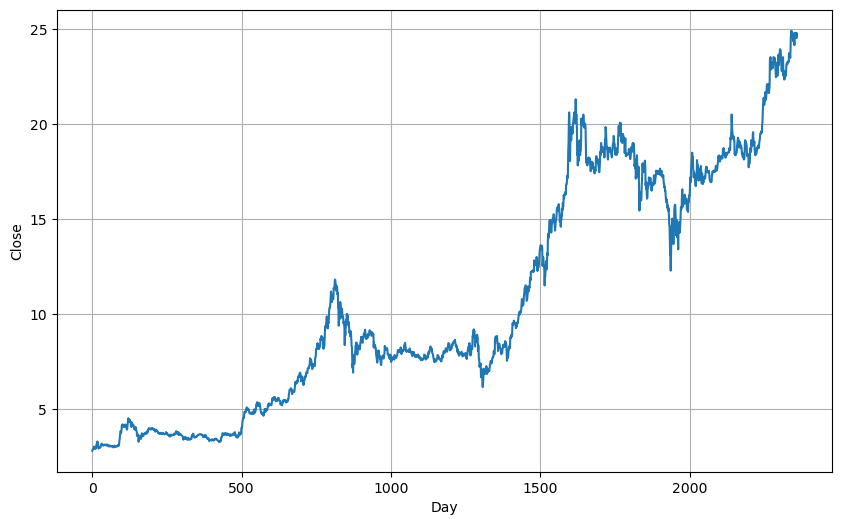

Epoch 1/100
73/73 [==============================] - 7s 33ms/step - loss: 7.5320 - mae: 8.0147
Epoch 2/100
73/73 [==============================] - 2s 30ms/step - loss: 1.7972 - mae: 2.2112
Epoch 3/100
73/73 [==============================] - 2s 29ms/step - loss: 0.7721 - mae: 1.1709
Epoch 4/100
73/73 [==============================] - 2s 30ms/step - loss: 0.5317 - mae: 0.9019
Epoch 5/100
73/73 [==============================] - 2s 30ms/step - loss: 0.3346 - mae: 0.6642
Epoch 6/100
73/73 [==============================] - 2s 28ms/step - loss: 0.2769 - mae: 0.6054
Epoch 7/100
73/73 [==============================] - 2s 30ms/step - loss: 0.2061 - mae: 0.5047
Epoch 8/100
73/73 [==============================] - 2s 30ms/step - loss: 0.1875 - mae: 0.4799
Epoch 9/100
73/73 [==============================] - 2s 30ms/step - loss: 0.1702 - mae: 0.4610
Epoch 10/100
73/73 [==============================] - 2s 29ms/step - loss: 0.1426 - mae: 0.4178
Epoch 11/100
73/73 [=============================

73/73 [==============================] - 3s 33ms/step - loss: 0.0468 - mae: 0.2206
Epoch 87/100
73/73 [==============================] - 3s 33ms/step - loss: 0.0555 - mae: 0.2499
Epoch 88/100
73/73 [==============================] - 3s 32ms/step - loss: 0.0457 - mae: 0.2158
Epoch 89/100
73/73 [==============================] - 3s 33ms/step - loss: 0.0501 - mae: 0.2335
Epoch 90/100
73/73 [==============================] - 3s 32ms/step - loss: 0.0466 - mae: 0.2223
Epoch 91/100
73/73 [==============================] - 3s 30ms/step - loss: 0.0485 - mae: 0.2264
Epoch 92/100
73/73 [==============================] - 3s 39ms/step - loss: 0.0544 - mae: 0.2440
Epoch 93/100
73/73 [==============================] - 3s 35ms/step - loss: 0.0610 - mae: 0.2615
Epoch 94/100
73/73 [==============================] - 3s 34ms/step - loss: 0.0548 - mae: 0.2487
Epoch 95/100
73/73 [==============================] - 2s 29ms/step - loss: 0.0461 - mae: 0.2193
Epoch 96/100
73/73 [==============================] -

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv

# Hàm vẽ dữ liệu
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Định nghĩa tham số
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
split_time = 3000

# Hàm tạo cửa sổ dữ liệu
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\ACB.csv')
data.head

# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\ACB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')
# Phân chia tập huấn luyện và xác thực
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
# Tạo mô hình
model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
])
   



# Set the learning rate
learning_rate = 1e-6
# Chuẩn bị dữ liệu cho mô hình
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)




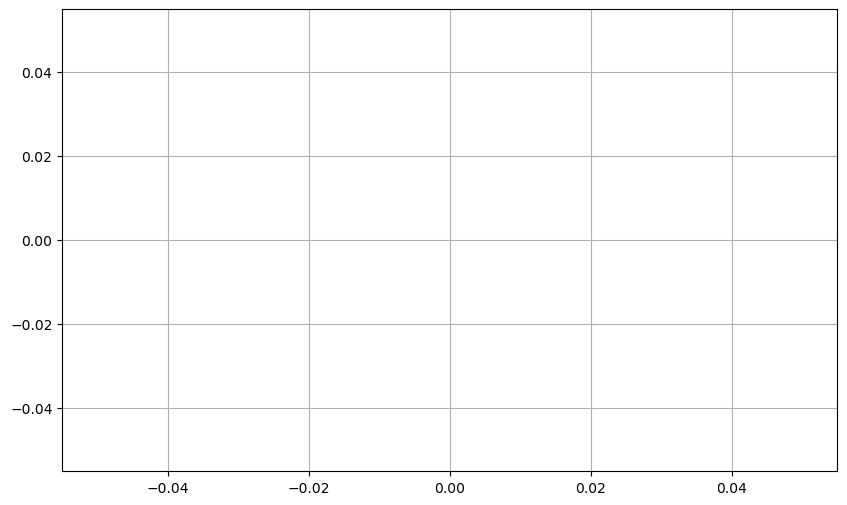

In [14]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))